# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry.

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

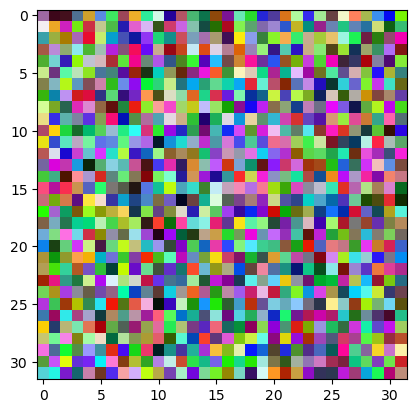

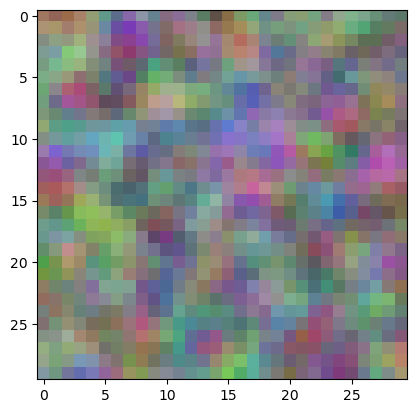

In [1]:
import torch
from matplotlib import pyplot as plt

tensor = torch.rand((1,3,32,32))

channel_connections = torch.eye(3)

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

blur = channel_connections.view(3,3,1,1)*filter

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor,blur)

plt.imshow(blurred[0].permute(1,2,0))
plt.show()


# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


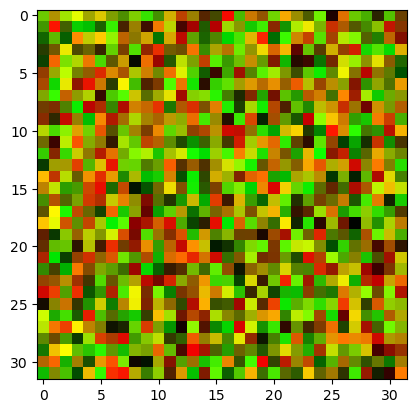

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


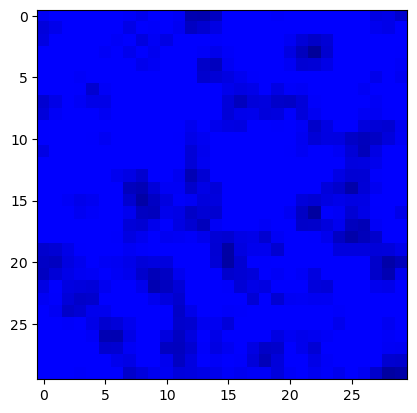

In [2]:
tensor = torch.rand((10,3,32,32))
tensor[:,2] = -7

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

rg_blur_to_b = torch.zeros(3,3,3,3)
rg_blur_to_b[2, 0] = filter
rg_blur_to_b[2, 1] = filter
blurred = torch.nn.functional.conv2d(tensor,rg_blur_to_b)

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

plt.imshow(blurred[0].permute(1,2,0))
plt.show()



# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

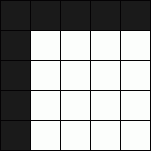

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

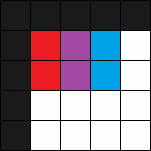
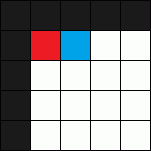


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [3]:
data_batch = torch.zeros(10,16,32,32)

#deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16,32,2)

conv_layer(data_batch).shape

torch.Size([10, 32, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak:

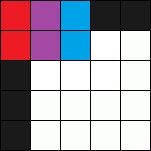

In [4]:
data_batch = torch.zeros(10,16,32,32)

conv_layer = torch.nn.Conv2d(16,16,2,padding=1)
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16,16,3,padding=1)
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

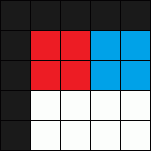


In [5]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,stride=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

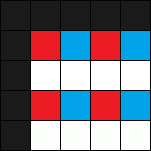

In [6]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,dilation=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

# Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [7]:
pool_layer =  torch.nn.MaxPool2d(2) #okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2,4)) #pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10,3,128,128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(data_batch).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling.

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [8]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics:
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              )
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

Files already downloaded and verified
Files already downloaded and verified


Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3.

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [18]:
class SimpleCNN(torch.nn.Module):
  def __init__(self,  channels: int,  labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", torch.nn.Conv2d(channels, 32, kernel_size=3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", torch.nn.Conv2d(32, 32, kernel_size=3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(32*32*8, labels))

  def forward(self, x):
    return self.model(x)

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [19]:
cnn_model = SimpleCNN(3, 10)
out = cnn_model(torch.zeros(128,3,32,32))
assert out.shape==(128,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())


8.57 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.47 ms ± 6.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [20]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

100%|██████████| 1563/1563 [00:06<00:00, 247.41it/s]


Epoch 0: train loss = 0.038 (acc: 0.566), validation loss = 0.039 (acc: 0.554)


100%|██████████| 1563/1563 [00:12<00:00, 121.43it/s]


Epoch 1: train loss = 0.032 (acc: 0.647), validation loss = 0.034 (acc: 0.620)


100%|██████████| 1563/1563 [00:05<00:00, 300.02it/s]


Epoch 2: train loss = 0.031 (acc: 0.653), validation loss = 0.034 (acc: 0.618)


100%|██████████| 1563/1563 [00:05<00:00, 275.14it/s]


Epoch 3: train loss = 0.028 (acc: 0.694), validation loss = 0.032 (acc: 0.647)


100%|██████████| 1563/1563 [00:05<00:00, 290.78it/s]


Epoch 4: train loss = 0.026 (acc: 0.713), validation loss = 0.031 (acc: 0.651)


# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [35]:
class CNN(torch.nn.Module):
  def __init__(self, channels: int,  kernel_size : int, labels: int, conv_layers_channels : list[int], pooling : bool):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("init_conv",  nn.Conv2d(channels, conv_layers_channels[0], kernel_size= 1)) # in_conv ma filtr = 1x1
    for i in range(len(conv_layers_channels) - 1):
      self.model.add_module(f"conv {i+1}", nn.Conv2d(conv_layers_channels[i], conv_layers_channels[i+1], kernel_size= kernel_size, padding=kernel_size//2))
      self.model.add_module(f"ReLU {i+1}", nn.ReLU())
      if pooling:
        self.model.add_module(f"MaxPool {i+1}", nn.MaxPool2d(2))
      else:
        self.model.add_module(f"stride conv { i + 1}",nn.Conv2d(conv_layers_channels[i+1], conv_layers_channels[i+1], kernel_size=kernel_size, stride=2, padding=kernel_size//2))
    final_size = 32 // (2**(len(conv_layers_channels) // 2))
    final_size = final_size * final_size * conv_layers_channels[-1] // 4
    self.model.add_module("flatten",  torch.nn.Flatten())
    self.model.add_module("Linear", nn.Linear(final_size, labels))
  def forward(self, x):
    return self.model(x)

Zweryfikuj działanie implementacji:

In [37]:
dummy_data = torch.zeros(37,3,32,32)

cnn_model = CNN(channels=3, kernel_size=5, conv_layers_channels = [16,32,64], labels=15, pooling=False) # utwórz CNN z: 15 etykietami wyjściowymi, filtrem 5x5, 3 warstwy conv z liczbą kanałów: 16,32,64, downsampling warstwą konwolucyjną
assert cnn_model(dummy_data).shape == (37,15)

cnn_model = CNN(channels=3, kernel_size=3, labels=10, pooling=True, conv_layers_channels=[8,16,32,64])# utwórz CNN: 10 etykiet wyjściowych, filtr 3x3, 4 warstwy conv z liczbą kanałów: 8,16,32,64, downsampling warstwą poolingu
assert cnn_model(dummy_data).shape == (37,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

13.9 ms ± 9.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.66 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [52]:
from sklearn.metrics import f1_score
import numpy as np

In [115]:
def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True
):
    train_loss_tab = []
    train_acc_tab = []
    val_loss_tab = []
    val_acc_tab = []
    targets_val = [] 
    preds_val = []
    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        if print_metrics:
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                train_loss_tab.append(train_loss.item())
                train_acc_tab.append(train_acc.item())
                val_loss_tab.append(val_loss.item())
                val_acc_tab.append(val_acc.item())
        for X_batch, y_batch in val_dl:
            y_pred = model(X_batch.cuda())
            _, predicted = torch.max(y_pred, 1)
            targets_val += y_batch.tolist()
            preds_val += predicted.tolist()

    return [train_loss_tab, train_acc_tab, val_loss_tab, val_acc_tab], f1_score(targets_val, preds_val, average='macro')
    

In [116]:
all_models_dict = {}
all_models_dict["kernel_size_3"] = CNN(channels = 3, conv_layers_channels = [16,32,64], kernel_size = 3, labels = 15, pooling = False).cuda()
all_models_dict["kernel_size_5"] = CNN(channels = 3, conv_layers_channels = [16,32,64], kernel_size = 5, labels = 15, pooling = False).cuda()

all_models_dict["pooling"] = CNN(channels = 3, conv_layers_channels = [16,32,64], kernel_size = 3, labels = 15, pooling = True).cuda()
all_models_dict["downsampling"] = CNN(channels = 3, conv_layers_channels = [16,32,64], kernel_size = 3, labels = 15, pooling = False).cuda()

all_models_dict["model_16_32_64"] = CNN(channels = 3, conv_layers_channels = [16,32,64], kernel_size = 3, labels = 15, pooling = False).cuda()
all_models_dict["model_32_32_32"] = CNN(channels = 3, conv_layers_channels = [32,32,32], kernel_size = 3, labels = 15, pooling = False).cuda()

num_epochs = 5

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:06<00:00, 242.17it/s]


[[0.03985156863927841, 0.030922016128897667, 0.028265999630093575, 0.02397845685482025, 0.02302698604762554], [0.545960009098053, 0.6613799929618835, 0.6821399927139282, 0.734559953212738, 0.7472800016403198], [0.041420768946409225, 0.033628061413764954, 0.03260480612516403, 0.030244015157222748, 0.030408674851059914], [0.5306999683380127, 0.6250999569892883, 0.6380000114440918, 0.6711999773979187, 0.6601999998092651]]


100%|██████████| 1563/1563 [00:08<00:00, 193.47it/s]


[[0.04156919941306114, 0.03552753105759621, 0.03310912847518921, 0.027652442455291748, 0.027362672612071037], [0.5318399667739868, 0.6044399738311768, 0.6322199702262878, 0.6970399618148804, 0.6983999609947205], [0.042443275451660156, 0.03771445155143738, 0.036753617227077484, 0.03323569521307945, 0.0347144678235054], [0.5205999612808228, 0.5828999876976013, 0.5945999622344971, 0.6306999921798706, 0.6250999569892883]]


100%|██████████| 1563/1563 [00:05<00:00, 262.91it/s]


[[0.037410762161016464, 0.030171742662787437, 0.02626100555062294, 0.023760048672556877, 0.021289747208356857], [0.5837399959564209, 0.6680600047111511, 0.7094199657440186, 0.7378599643707275, 0.7674399614334106], [0.03850754722952843, 0.03279769420623779, 0.030350161716341972, 0.029205605387687683, 0.028157437220215797], [0.5665000081062317, 0.638700008392334, 0.6668999791145325, 0.6782000064849854, 0.691100001335144]]


100%|██████████| 1563/1563 [00:07<00:00, 215.31it/s]


[[0.039381615817546844, 0.03106822445988655, 0.028017418459057808, 0.0253291055560112, 0.023686284199357033], [0.5592199563980103, 0.6530399918556213, 0.6890199780464172, 0.718999981880188, 0.7384999990463257], [0.0404525063931942, 0.03383424133062363, 0.03164931386709213, 0.03050367347896099, 0.030756274238228798], [0.5496999621391296, 0.6207999587059021, 0.6459999680519104, 0.6685999631881714, 0.6640999913215637]]


100%|██████████| 1563/1563 [00:07<00:00, 219.44it/s]


[[0.03746125474572182, 0.028944363817572594, 0.026270370930433273, 0.023234616965055466, 0.022771203890442848], [0.5753200054168701, 0.676580011844635, 0.7079799771308899, 0.7446199655532837, 0.7522199749946594], [0.03877097740769386, 0.031774286180734634, 0.030477337539196014, 0.02968221716582775, 0.03016667440533638], [0.562999963760376, 0.6485999822616577, 0.663599967956543, 0.6746999621391296, 0.6672999858856201]]


100%|██████████| 1563/1563 [00:07<00:00, 215.34it/s]


[[0.0381605438888073, 0.03204076364636421, 0.028367890045046806, 0.025229090824723244, 0.024372465908527374], [0.5685999989509583, 0.6420800089836121, 0.6881600022315979, 0.7203399538993835, 0.7309799790382385], [0.03913953900337219, 0.034392066299915314, 0.03165638446807861, 0.030039595440030098, 0.030493127182126045], [0.5511000156402588, 0.6157000064849854, 0.6506999731063843, 0.6668999791145325, 0.6622999906539917]]


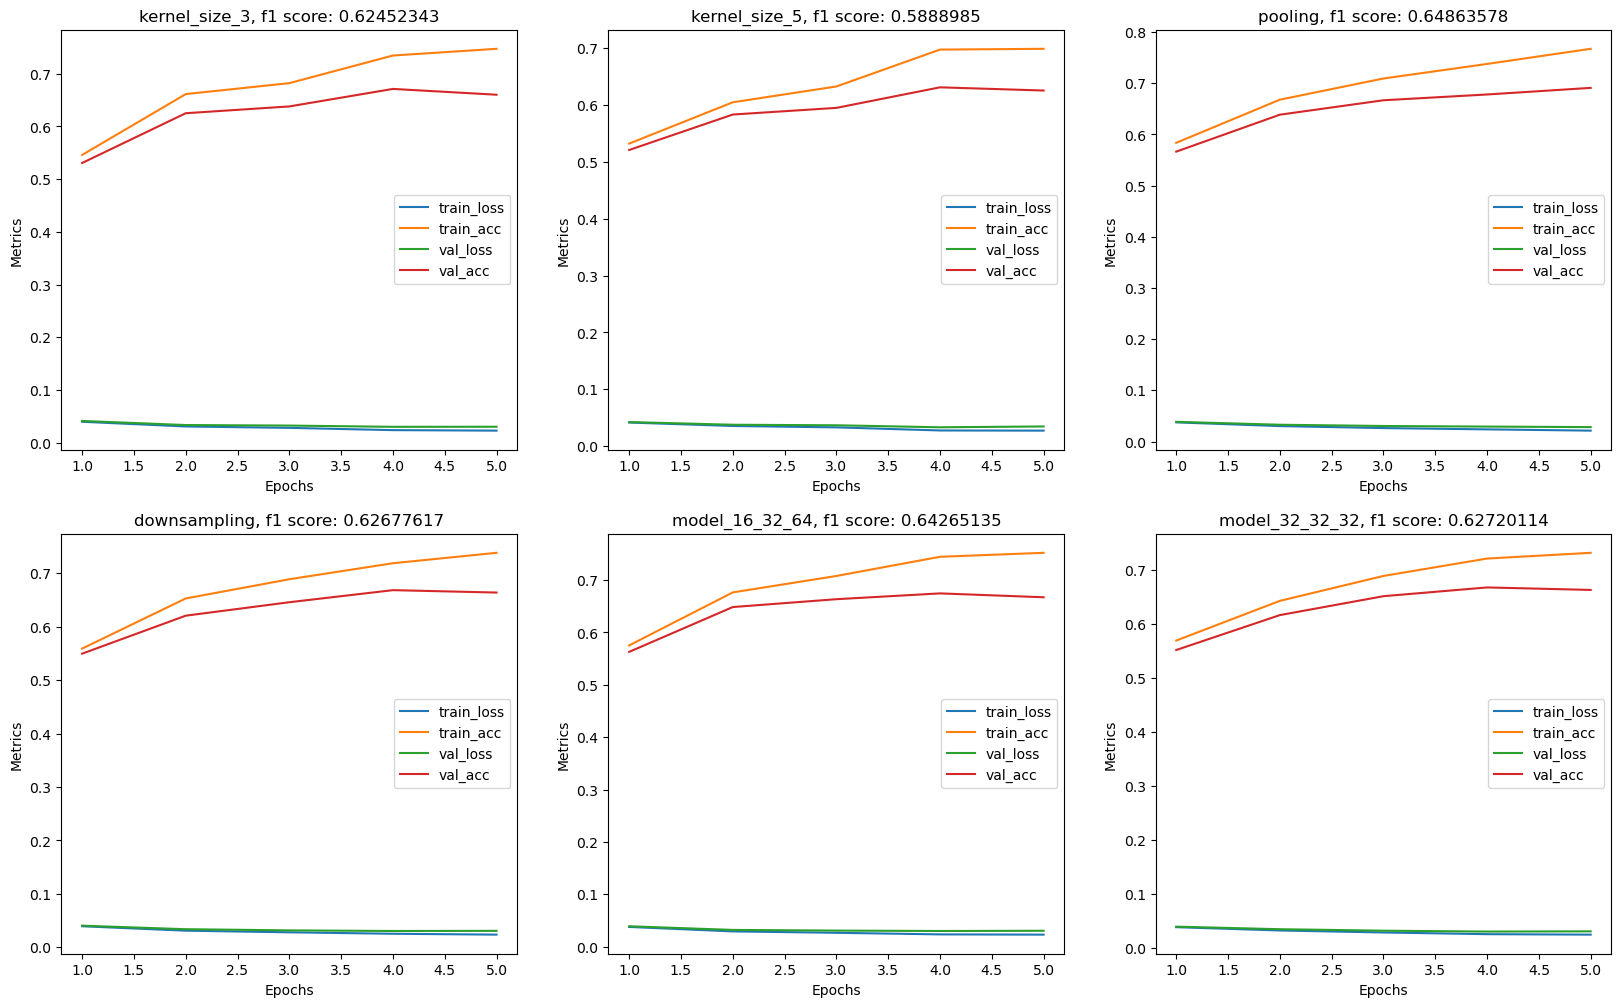

In [117]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))
axtab = [ax1, ax2, ax3, ax4, ax5, ax6]
loss_fn = torch.nn.CrossEntropyLoss()
xs = np.arange(1, num_epochs + 1)
for i, modelname in enumerate(all_models_dict.keys()):
    optimizer = optim.Adam(all_models_dict[modelname].parameters(), lr=0.001)
    results, f1 = fit(all_models_dict[modelname], optimiser=optimizer, loss_fn=loss_fn, train_dl=train_dl, val_dl= test_dl, epochs=num_epochs)
    print(results)
    resnames = ['train_loss', 'train_acc', 'val_loss', 'val_acc']
    for j in range(4):
        axtab[i].plot(xs, results[j], label = resnames[j])
        axtab[i].set_xlabel("Epochs")
        axtab[i].set_ylabel("Metrics")
        axtab[i].set_title(f"{modelname}, f1 score: {np.round(f1, 8)}")
        axtab[i].legend()